## Problem Statement

Congratulations! You have just been hired by the American Institute of Health. The Institute monitors disease epidemics in both foreign and domestic lands. A critical component of the monitoring process is analyzing published news data. Each day, the Institute receives hundreds of news headlines describing disease outbreaks in various locations. The news headlines are too numerous to be analyzed by hand.

Your first assignment is as follows: You will process the daily quota of news headlines and extract locations that are mentioned You will then cluster the headlines based on their geographic distribution. Finally, you will review the largest clusters within and outside the United States. Any interesting findings should be reported to your immediate superior.

## Approach:
- Extracting and visualizing locations
- Cleaning data
- Clustering locations

In [ ]:
!pip install unidecode
!pip install geopy
!pip install geonamescache
!pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 15.3 MB/s eta 0:00:00


In [ ]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.feature import NaturalEarthFeature
from cartopy.io.shapereader import Reader
from math import asin, cos, sin
from unidecode import unidecode
from geonamescache import GeonamesCache

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

gc = GeonamesCache()

In [ ]:
try:
  headline_file = open('headlines.txt','r')
  headlines = [line.strip()
               for line in headline_file.readlines()]
  num_headlines = len(headlines)
  print(f"{num_headlines} headlines have been loaded")
except FileNotFoundError:
  print("Error: 'headlines.txt' not found. Please ensure the file exists in the same directory.")

650 headlines have been loaded


In [ ]:

# Defining regex to patterns
def name_to_regex(name):
    """Converts a name to a regular expression that matches the name with or without accents and case.

    Args:
        name (str): The name to convert to a regex.

    Returns:
        re.Pattern: A compiled regular expression object.
    """
    decoded_name = unidecode(name)
    if name != decoded_name:
        regex = fr'\b({name}|{decoded_name})\b'
    else:
        regex = fr'\b{name}\b'
    return re.compile(regex, flags=re.IGNORECASE)




In [ ]:
# Applying regex pattern to get city and country from the headlines

countries = [country['name']
             for country in gc.get_countries().values()]
country_to_name = {name_to_regex(name): name
                   for name in countries}
cities = [city['name'] for city in gc.get_cities().values()]
city_to_name = {name_to_regex(name): name for name in cities}

In [ ]:
# Finding location in the text

def get_name_in_text(text, dictionary):
    for regex, name in sorted(dictionary.items(),
                              key=lambda x: x[1]):
        if regex.search(text):
            return name
    return None

In [ ]:
# Getting the countries and the cities

matched_countries = [get_name_in_text(headline, country_to_name)
                     for headline in headlines]
matched_cities = [get_name_in_text(headline, city_to_name)
                  for headline in headlines]
data = {'Headline': headlines, 'City': matched_cities,
        'Country': matched_countries}
df = pd.DataFrame(data)

In [ ]:
summary = df[['City', 'Country']].describe()
print(summary)

       City Country
count   618      15
unique  511      10
top      Of  Brazil
freq     44       3


In [ ]:
df.City.value_counts().head(5)

,count
City,
Of,44
San,11
Miami,7
Comé,7
Hīt,5


In [ ]:
df.Country.value_counts().head(4)

,count
Country,
Brazil,3
Malaysia,3
Panama,2
Vietnam,1


Highest occuring city name seems to be `Of`, which doesnt seem correct. Lets investigate!

In [ ]:
of_cities = df[df.City == 'Of'][['City', 'Headline']]
ten_of_cities = of_cities.head(10)
print(ten_of_cities.to_string(index=False))

City                                                                Headline
  Of                                   Case of Measles Reported in Vancouver
  Of Authorities are Worried about the Spread of Bronchitis in Silver Spring
  Of     Authorities are Worried about the Spread of Mad Cow Disease in Rome
  Of                    Rochester authorities confirmed the spread of Dengue
  Of                          Tokyo Encounters Severe Symptoms of Meningitis
  Of       Authorities are Worried about the Spread of Influenza in Savannah
  Of                                 Spike of Pneumonia Cases in Springfield
  Of                     The Spread of Measles in Spokane has been Confirmed
  Of                                         Outbreak of Zika in Panama City
  Of                         Urbana Encounters Severe Symptoms of Meningitis


In [ ]:
# prompt: How do i find if the headline contains Vancouver in its content ?

vancouver_headlines = df[df['Headline'].str.contains('Vancouver', case=False)]
print(vancouver_headlines)

#silverspring_headlines = df[df['Headline'].str.contains('Silver Spring', case=False)]
#print(silverspring_headlines)

                                           Headline             City Country
53            Case of Measles Reported in Vancouver               Of    None
506  Chikungunya Keeps Spreading in North Vancouver  North Vancouver    None


In [ ]:
#df.loc[74]

It seems when the city is present in multiple instances, there is wrong conclusion for city name as `Of`.  Lets try to tackle the problem by adding one more column `Cities` for multiple names occuring in the headline (Lets also add a column for number of cities).

In [ ]:
def get_cities_in_headline(headline):
    cities_in_headline = set()
    for regex, name in city_to_name.items():
        match = regex.search(headline)
        if match:
            if headline[match.start()].isupper():
                cities_in_headline.add(name)

    return list(cities_in_headline)

In [ ]:
df['Cities'] = df['Headline'].apply(get_cities_in_headline)
df['Num_cities'] = df['Cities'].apply(len)

In [ ]:
df_multiple_cities = df[df.Num_cities > 1]
num_rows, _ = df_multiple_cities.shape
print(f"{num_rows} headlines match multiple cities")

72 headlines match multiple cities


In [ ]:
# Lets check 10 of them (headlines with multiple cities) now
df_multiple_cities[['Cities', 'Headline']].head(10)

,Cities,Headline
1,"[New York City, York]",Could Zika Reach New York City?
2,"[Miami, Miami Beach]",First Case of Zika in Miami Beach
12,"[San, San Juan]",San Juan reports 1st U.S. Zika-related death a...
16,"[Los Angeles, Los Ángeles]",New Los Angeles Hairstyle goes Viral
21,"[Bay, Tampa]",Tampa Bay Area Zika Case Count Climbs
25,"[Ho Chi Minh City, Ho]",Zika cases in Vietnam's Ho Chi Minh City surge
29,"[San, San Diego]",Key Zika Findings in San Diego Institute
33,"[Kuala Lumpur, Hīt]",Kuala Lumpur is Hit By Zika Threat
36,"[San, San Francisco]",Zika Virus Reaches San Francisco
41,"[San, San Salvador, Salvador]",Zika worries in San Salvador


It seems we have to get the longest unique city name. Example, observe `San` vs `San Juan`, `San Diego`, `San Francisco`, `San Salvador`.

In [ ]:
def get_longest_city(cities):
    if cities:
        return max(cities, key=len)
    return None

In [ ]:
# Lets apply the above defined rule
df['City'] = df['Cities'].apply(get_longest_city)


In [ ]:
# Lets also check the short city names
df[df.City.str.len() <= 4][['City', 'Headline']]

,City,Headline
45,Lima,Lima tries to address Zika Concerns
71,Pune,Pune woman diagnosed with Zika
80,Rome,Authorities are Worried about the Spread of Ma...
130,Molo,Molo Cholera Spread Causing Concern
171,Miri,Zika arrives in Miri
273,Nadi,More people in Nadi are infected with HIV ever...
283,Baud,Rumors about Tuberculosis Spreading in Baud ha...
320,Kobe,Chikungunya re-emerges in Kobe
363,Waco,More Zika patients reported in Waco
365,Erie,Erie County sets Zika traps


In [ ]:
# We have only 15 countries from the headlines. Lets check them now

df_countries = df[df.Country.notnull()][['City', 'Country', 'Headline']]
df_countries

,City,Country,Headline
3,Recife,Brazil,"Mystery Virus Spreads in Recife, Brazil"
25,Ho Chi Minh City,Vietnam,Zika cases in Vietnam's Ho Chi Minh City surge
30,Bangkok,Thailand,Thailand-Zika Virus in Bangkok
44,Piracicaba,Brazil,"Zika outbreak in Piracicaba, Brazil"
58,Klang,Malaysia,"Zika surfaces in Klang, Malaysia"
59,Guatemala City,Guatemala,Rumors about Meningitis spreading in Guatemala...
77,Belize City,Belize,Belize City under threat from Zika
78,Campinas,Brazil,"Student sick in Campinas, Brazil"
83,Mexico City,Mexico,Zika outbreak spreads to Mexico City
124,Kota Kinabalu,Malaysia,"New Zika Case in Kota Kinabalu, Malaysia"


Lets delete the country column totally. Next, assign geographical coordinates to another column.

In [ ]:
df_unmatched = df[df.City.isnull()]
num_unmatched = len(df_unmatched)

In [ ]:
print(f"{num_unmatched} headlines contain no city matches.")
print(df_unmatched.head(10)[['Headline']].values)

39 headlines contain no city matches.
[['Louisiana Zika cases up to 26']
 ['Zika infects pregnant woman in Cebu']
 ['Spanish Flu Sighted in Antigua']
 ['Zika case reported in Oton']
 ['Maka City Experiences Influenza Outbreak']
 ['West Nile Virus Outbreak in Saint Johns']
 ['Syphilis Hits Jefferson']
 ['Malaria Exposure in Sussex']
 ['Greenwich Establishes Zika Task Force']
 ['Will West Nile Virus vaccine help Parsons?']]


There are some names which are not any city, but instead an organization (eg, `Fort Belvoir`). Also, there are some cities which GeoNameCache fail to identify.

In [ ]:
len(df_unmatched)/len(df)

0.06

Approximately 6% of the headlines do not match any cities. Some of these headlines mention legitimate cities, which GeoNamesCache failed to identify. Since this is a small number, we drop those rows.

In [ ]:
df = df[~df.City.isnull()][['City', 'Headline']]

## Visualizing and clustering the extracted location data

In [ ]:
# Assigning geographic coordinates to cities
latitudes, longitudes = [], []
for city_name in df.City.values:
    city = max(gc.get_cities_by_name(city_name),key=lambda x: list(x.values())[0]['population'])
    city = list(city.values())[0]
    latitudes.append(city['latitude'])
    longitudes.append(city['longitude'])

df = df.assign(Latitude=latitudes, Longitude=longitudes)

In [ ]:
df.head()

,City,Headline,Latitude,Longitude
0,Miami,Zika Outbreak Hits Miami,25.77427,-80.19366
1,New York City,Could Zika Reach New York City?,40.71427,-74.00597
2,Miami Beach,First Case of Zika in Miami Beach,25.79065,-80.13005
3,Recife,"Mystery Virus Spreads in Recife, Brazil",-8.05389,-34.88111
4,Dallas,Dallas man comes down with case of Zika,32.78306,-96.80667


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

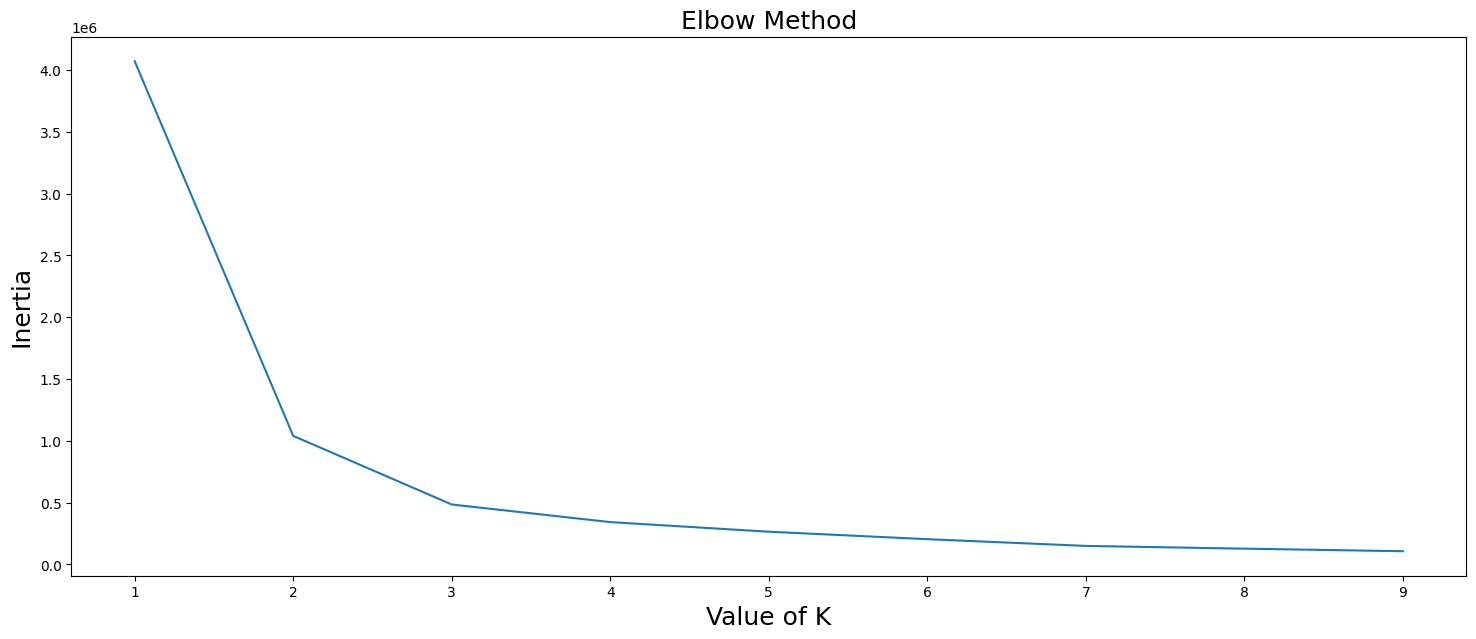

In [ ]:
# Elbow method to get the `K`

coordinates = df[['Latitude', 'Longitude']].values
k_values = range(1,10)
inertia_values = []

for k in k_values:
    inertia_values.append(KMeans(k).fit(coordinates).inertia_)

plt.figure(figsize=(18,7))
plt.plot(range(1,10), inertia_values)
plt.xticks(range(1,10))
plt.title('Elbow Method', fontsize = 18)
plt.xlabel('Value of K', fontsize = 18)
plt.ylabel('Inertia', fontsize = 18)
plt.show();

In [ ]:
def plot_clusters(clusters, longitudes, latitudes):
    plt.figure(figsize=(12, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    ax.scatter(longitudes, latitudes, c=clusters)
    ax.set_global()
    plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


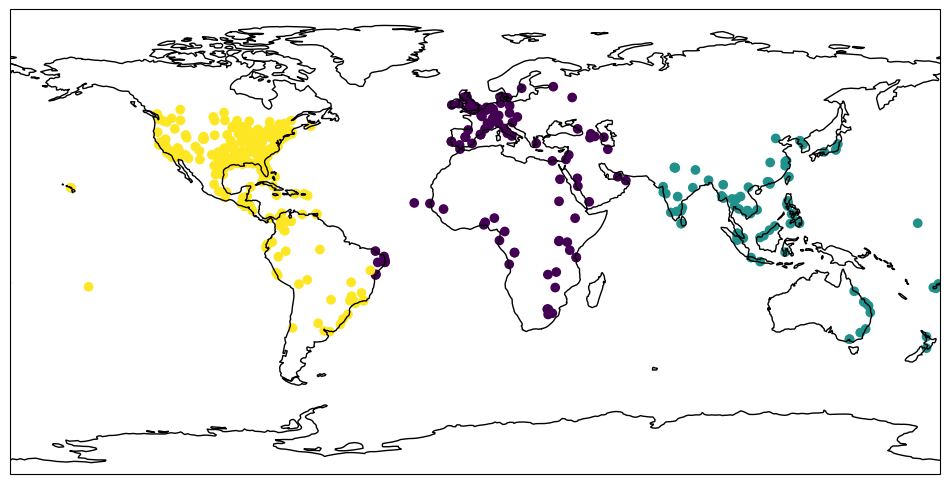

In [ ]:
df['Cluster'] = KMeans(3).fit_predict(coordinates)
plot_clusters(df.Cluster, df.Longitude, df.Latitude)

We only see 3 regions:
- North and South America
- Africa and Europe
- Asia and Australia

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


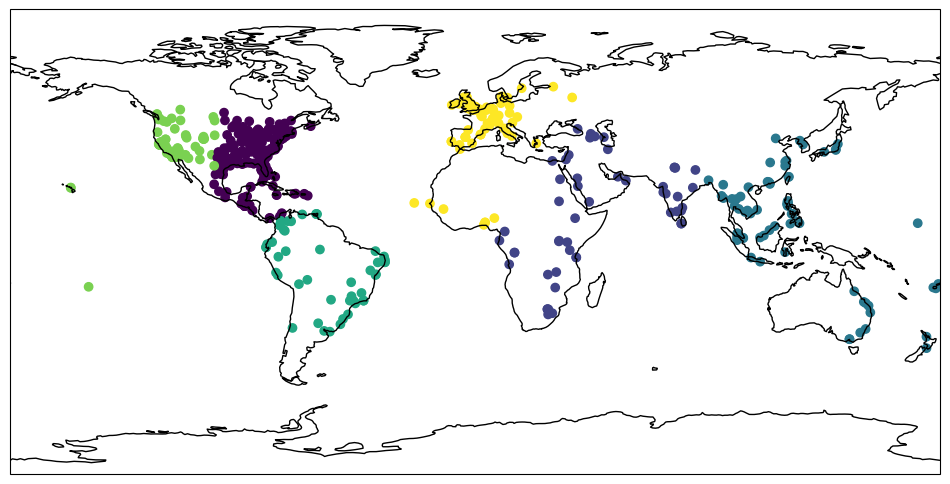

In [ ]:
# Lets try with k = 6

df['Cluster'] = KMeans(6).fit_predict(coordinates)
plot_clusters(df.Cluster, df.Longitude, df.Latitude)

We can see that Asia and Australia are in same cluster. Also, Africa doesnt seem to be well distinguished. Lets try out DBSCAN now. We start by coding a great-circle distance function whose inputs are a pair of NumPy arrays.

In [ ]:
def great_circle_distance(coord1, coord2, radius=3956):
    if np.array_equal(coord1, coord2):
        return 0.0

    coord1, coord2 = np.radians(coord1), np.radians(coord2)
    delta_x, delta_y = coord2 - coord1
    haversin = sin(delta_x / 2) ** 2 + np.product([cos(coord1[0]),
                                                   cos(coord2[0]),
                                                   sin(delta_y / 2) ** 2])
    return  2 * radius * asin(haversin ** 0.5)

In [ ]:
metric = great_circle_distance
dbscan = DBSCAN(eps=250, min_samples=3, metric=metric)
df['Cluster'] = dbscan.fit_predict(coordinates)

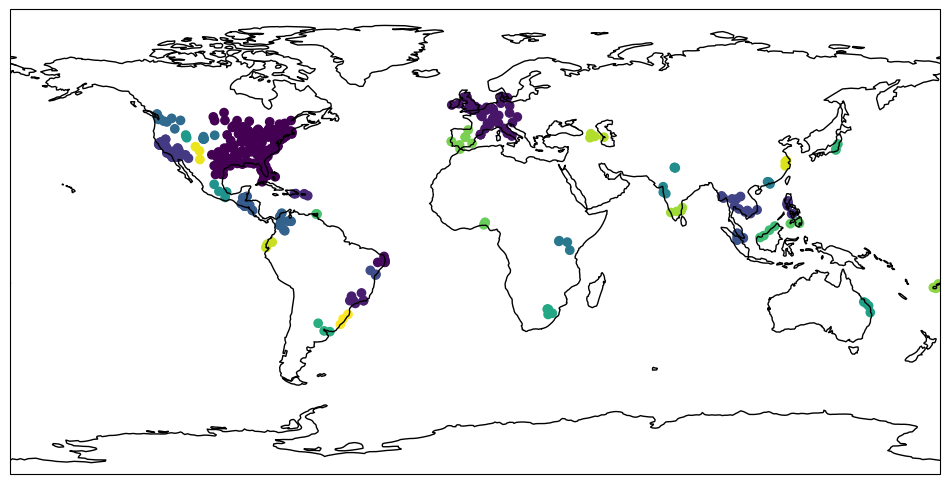

In [ ]:
# DBSCAN assigns –1 to outlier data points that do not cluster. We may remove that
df_no_outliers = df[df.Cluster > -1]
plot_clusters(df_no_outliers.Cluster, df_no_outliers.Longitude,
              df_no_outliers.Latitude)

We can see the narrative bias from the way clustering has happened, when we look at the Eastern US and some other similar clusters. Other parts have been sparsely mentioned. So, lets recluster US cities using a more rigorous epsilon parameter, leaving it out from rest of the part of the world.

In [ ]:
def get_country_code(city_name):
    city = max(gc.get_cities_by_name(city_name),
               key=lambda x: list(x.values())[0]['population'])
    return list(city.values())[0]['countrycode']

df['Country_code'] = df.City.apply(get_country_code)

In [ ]:
df_us = df[df.Country_code == 'US']
df_not_us = df[df.Country_code != 'US']

In [ ]:
# Reclustering extracted cities
def re_cluster(input_df, eps):
    input_coord = input_df[['Latitude', 'Longitude']].values
    dbscan = DBSCAN(eps=eps, min_samples=3,
                    metric=great_circle_distance)
    clusters = dbscan.fit_predict(input_coord)
    input_df = input_df.assign(Cluster=clusters)
    return input_df[input_df.Cluster > -1]

In [ ]:
df_not_us = re_cluster(df_not_us, 250)
df_us = re_cluster(df_us, 125)

## Extracting insights from location clusters

In [ ]:
groups = df_not_us.groupby('Cluster')
num_groups = len(groups)
print(f"{num_groups} Non-US clusters have been detected")

32 Non-US clusters have been detected


In [ ]:
# Finding the largest cluster
sorted_groups = sorted(groups, key=lambda x: len(x[1]), reverse=True)
group_id, largest_group = sorted_groups[0]
group_size = len(largest_group)
print(f"Largest cluster contains {group_size} headlines")

Largest cluster contains 51 headlines


In [ ]:
# Computing cluster centrality
'''
compute_centrality function assigns a Distance_to_center column to an inputted group
'''
def compute_centrality(group):
    group_coords = group[['Latitude', 'Longitude']].values
    center = group_coords.mean(axis=0)
    distance_to_center = [great_circle_distance(center, coord)
                          for coord in group_coords]
    group['Distance_to_center'] = distance_to_center

In [ ]:
# Finding the central headlines in the largest cluster
def sort_by_centrality(group):
    compute_centrality(group)
    return group.sort_values(by=['Distance_to_center'], ascending=True)

largest_group = sort_by_centrality(largest_group)
for headline in largest_group.Headline.values[:5]:
    print(headline)

Mad Cow Disease Disastrous to Brussels
Scientists in Paris to look for answers
More Livestock in Fontainebleau are infected with Mad Cow Disease
Mad Cow Disease Hits Rotterdam
Contaminated Meat Brings Trouble for Bonn Farmers


<ipython-input-44-c282a3c5587c>:5: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  distance_to_center = [great_circle_distance(center, coord)


It seems these are European countries. Lets find out for this cluster, and for the other ones as well.

In [ ]:
#  Finding the top three countries in the largest cluster
from collections import Counter
def top_countries(group):
    countries = [gc.get_countries()[country_code]['name']
                 for country_code in group.Country_code.values]
    return Counter(countries).most_common(10)


print(top_countries(largest_group))

[('United Kingdom', 19), ('France', 7), ('Germany', 6), ('Italy', 4), ('Switzerland', 3), ('Spain', 3), ('Ireland', 2), ('Denmark', 2), ('Belgium', 1), ('Netherlands', 1)]


In [ ]:
# Summarizing content in the largest clusters
for _, group in sorted_groups[1:5]:
    sorted_group = sort_by_centrality(group);
    print(f"Cluster contains {len(sorted_group)} headlines. Top 5 headlines are as below:")
    print(top_countries(sorted_group));
    for headline in sorted_group.Headline.values[:5]:
        print(headline);
    print('\n')

Cluster contains 16 headlines. Top 5 headlines are as below:
[('Philippines', 16)]
Zika afflicts patient in Calamba
Hepatitis E re-emerges in Santa Rosa
More Zika patients reported in Indang
Batangas Tourism Takes a Hit as Virus Spreads
Spreading Zika reaches Bacoor


Cluster contains 12 headlines. Top 5 headlines are as below:
[('Thailand', 5), ('Cambodia', 3), ('Vietnam', 2), ('Myanmar', 2)]
More Zika patients reported in Chanthaburi
Thailand-Zika Virus in Bangkok
Zika case reported in Phetchabun
Zika arrives in Udon Thani
More Zika patients reported in Kampong Speu


Cluster contains 10 headlines. Top 5 headlines are as below:
[('El Salvador', 3), ('Guatemala', 2), ('Belize', 2), ('Nicaragua', 2), ('Honduras', 1)]
Zika Reported in Ilopango
More Zika cases in Soyapango
Zika worries in San Salvador
Zika arrives in Tegucigalpa
Rumors about Meningitis spreading in Guatemala City have been refuted


Cluster contains 10 headlines. Top 5 headlines are as below:
[('Canada', 10)]
Rumors abou

<ipython-input-44-c282a3c5587c>:5: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  distance_to_center = [great_circle_distance(center, coord)
<ipython-input-44-c282a3c5587c>:5: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  distance_to_center = [great_circle_distance(center, coord)
<ipython-input-44-c282a3c5587c>:5: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  distance_to_center = [great_circle_distance(center, coord)
<ipython-input-44-c282a3c5587c>:5: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  distance_to_center = [great_circle_distance(center, coord)


Zika is spreading through the Philippines! There are also Zika outbreaks in Southeast Asia and in Central America. The Canadian cluster, however, contains a mix of random disease headlines, which implies that no dominant outbreak is occurring in that northern territory.

Let’s turn our attention to the US clusters. We start by visualizing the clusters on a map of the United States

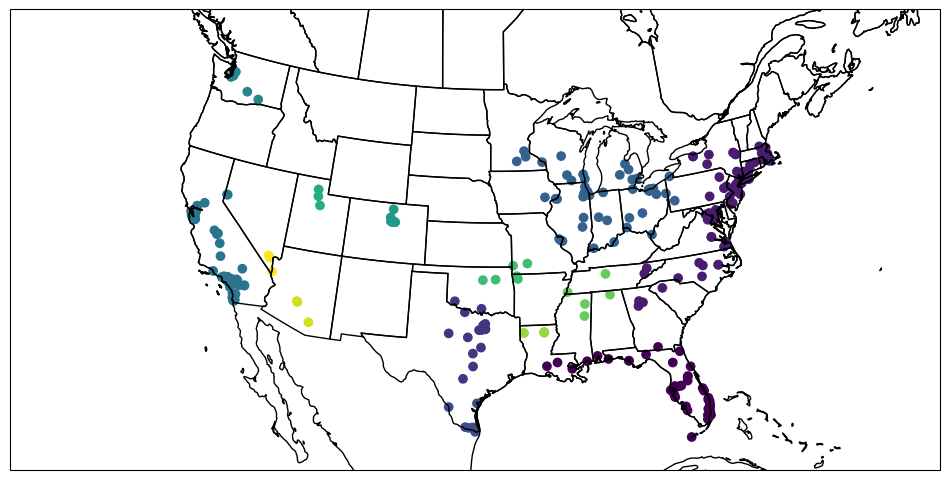

In [ ]:
# Plotting US DBSCAN clusters
plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.LambertConformal())
us_extent = [-130, -65, 20, 50]  # [west longitude, east longitude, south latitude, north latitude]
ax.set_extent(us_extent)
ax.scatter(df_us.Longitude, df_us.Latitude, c=df_us.Cluster,
              transform=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(ccrs.cartopy.feature.STATES)
plt.show()

In [ ]:
# Summarizing content within the largest US clusters
us_groups = df_us.groupby('Cluster')
us_sorted_groups = sorted(us_groups, key=lambda x: len(x[1]),
                         reverse=True)
for _, group in us_sorted_groups[:5]:
    sorted_group = sort_by_centrality(group)
    for headline in sorted_group.Headline.values[:5]:
        print(headline)
    print('\n')

Schools in Bridgeton Closed Due to Mumps Outbreak
Philadelphia experts track pandemic
Vineland authorities confirmed the spread of Chlamydia
Baltimore plans for Zika virus
Will Swine Flu vaccine help Annapolis?


Bradenton Experiences Zika Troubles
New Zika Case Confirmed in Sarasota County
Tampa Bay Area Zika Case Count Climbs
Zika Strikes St. Petersburg
Zika spreads to Plant City


Rhinovirus Hits Bakersfield
Schools in Tulare Closed Due to Mumps Outbreak
New medicine wipes out West Nile Virus in Ventura
New medicine wipes out Measles in Fresno
Authorities are Worried about the Spread of Varicella in Clovis


How to Avoid Hepatitis E in South Bend
Hepatitis E Hits Hammond
Chicago's First Zika Case Confirmed
Rumors about Hepatitis C spreading in Darien have been refuted
Rumors about Rotavirus Spreading in Joliet have been Refuted


More Zika patients reported in Fort Worth
Outbreak of Zika in Stephenville
Zika symptoms spotted in Arlington
Dallas man comes down with case of Zika
Zika 

<ipython-input-44-c282a3c5587c>:5: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  distance_to_center = [great_circle_distance(center, coord)
<ipython-input-44-c282a3c5587c>:5: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  distance_to_center = [great_circle_distance(center, coord)
<ipython-input-44-c282a3c5587c>:5: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  distance_to_center = [great_circle_distance(center, coord)
<ipython-input-44-c282a3c5587c>:5: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  distance_to_center = [great_circle_distance(center, coord)
<ipython-input-44-c282a3c5587c>:5: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be remov

The Zika epidemic has hit both Florida and Texas! This is very troubling. However, no discernible disease patterns are present in the other top clusters. Currently, the spreading Zika outbreak is confined to the southern United States.

In [ ]:
# Plotting Zika clusters
def count_zika_mentions(headlines):
    zika_regex = re.compile(r'\bzika\b',
                            flags=re.IGNORECASE)
    zika_count = 0
    for headline in headlines:
        if zika_regex.search(headline):
            zika_count += 1

    return zika_count

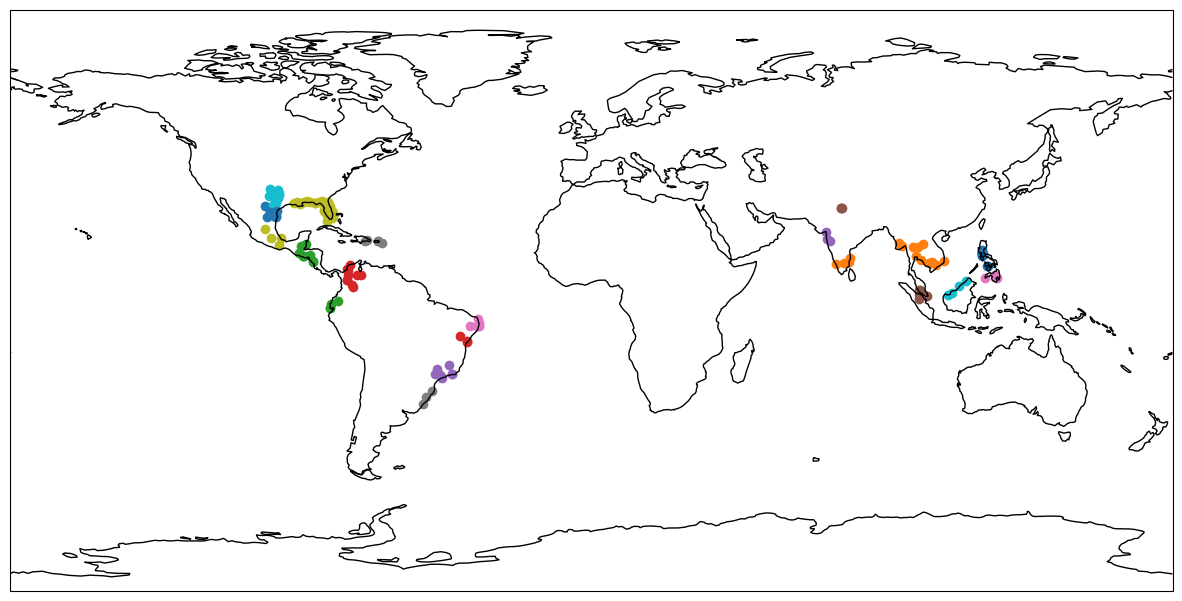

In [ ]:
fig = plt.figure(figsize=(15, 15))
ax = plt.axes(projection=ccrs.PlateCarree())

for _, group in sorted_groups + us_sorted_groups:
    headlines = group.Headline.values
    zika_count = count_zika_mentions(headlines)
    if float(zika_count) / len(headlines) > 0.5:
        ax.scatter(group.Longitude, group.Latitude)

ax.coastlines()
ax.set_global()
plt.show()

**Reference** : Data Science Bookcamp
By Leonard Apeltsin